In [26]:
from glob import glob
from PIL import Image

from rafic.birds_data import BirdsDataset, get_birds_dataloader, load_embedding
from rafic.evaluation import Evaluation
from rafic.search import CLIPSearch

## search

In [2]:
cs = CLIPSearch()

INFO 2023-11-10 20:56:42,348 search.py(93) Encoding input text query...
INFO 2023-11-10 20:56:42,388 search.py(97) Text encoded!


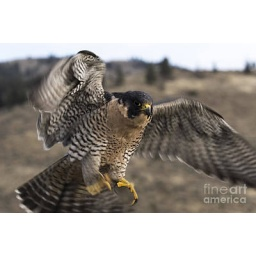

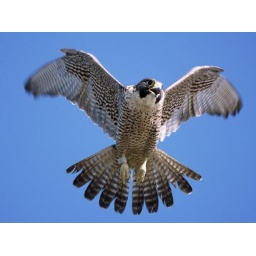

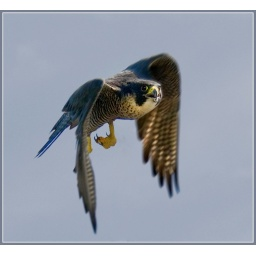

In [50]:
cs.show_images_by_key(
    cs.search_given_text(text='photo of a falcon', n=3)
)

## get a random bird image from the dataset

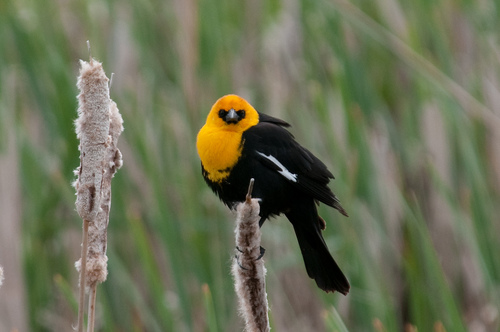

In [54]:
np.random.seed(10)
paths = glob('data/birds/CUB_200_2011/CUB_200_2011/images/*/*.jpg')
path = np.random.choice(paths)
Image.open(path)

#### find similar images

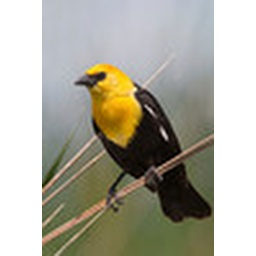

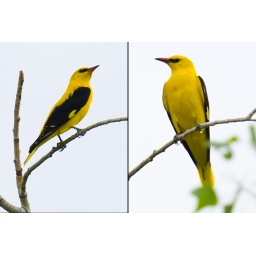

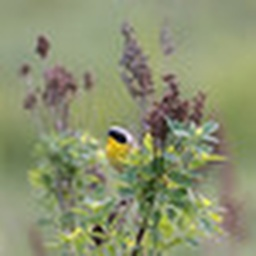

In [55]:
cs.show_images_by_key(
    cs.search_given_emb(load_embedding(path=path), n=3)
)

## evaluate

In [39]:
dl = get_birds_dataloader(
    split='val',
    batch_size=16,
    num_way=5,
    num_support=1,
    num_query=1,
    num_tasks_per_epoch=200,
    num_workers=8,
    seed=0,
    num_aug=0,
)

### random guessing: expected value is 1/N

In [6]:
%%time
Evaluation.eval_random(dl=dl, seed=0)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 287 ms, sys: 2.21 s, total: 2.5 s
Wall time: 1min 8s


0.18229166666666666

### Non-parametric nearest neighbors approach
1. compute mean of support embeddings belonging to the same class
2. for each query image, map it to the closest centroid

In [7]:
%%time
Evaluation.eval_non_parametric_nn(dl=dl)

  0%|          | 0/12 [00:01<?, ?it/s]

CPU times: user 9.74 s, sys: 2.48 s, total: 12.2 s
Wall time: 1min 4s


0.403125

### Linear classifier
1. Train a logisitc regression (LR) model on the support embeddings
2. Predict the class for each query image using LR

In [14]:
%%time
Evaluation.eval_clf(dl=dl, seed=0)

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 5.83 s, sys: 2.1 s, total: 7.93 s
Wall time: 48.6 s


0.9791666666666666

In [40]:
def run_lr_exp(num_support, num_aug):
    dl = get_birds_dataloader(
        split='val',
        batch_size=16,
        num_way=5,
        num_support=num_support,
        num_query=1,
        num_tasks_per_epoch=200,
        num_workers=8,
        seed=0,
        num_aug=num_aug,
    )
    return Evaluation.eval_clf(dl=dl, seed=0)

In [ ]:
df_lr = pd.DataFrame(
    dict(
        num_support=num_support,
        num_aug=num_aug,
        acc=run_lr_exp(
            num_support=num_support,
            num_aug=num_aug,
        )
    )
    for num_support in (1, 2, 5)
    for num_aug in (0, 1, 2, 5)
)

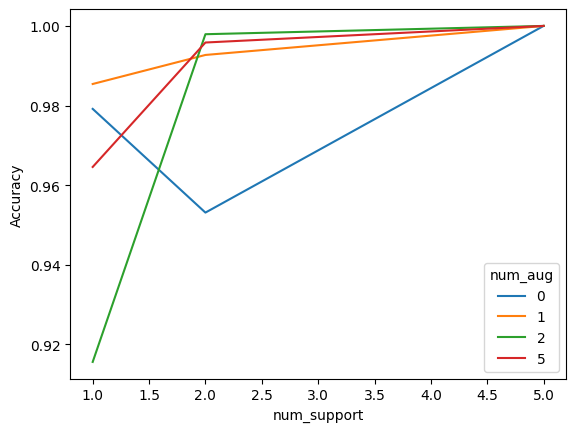

In [48]:
df_lr.pivot_table(index='num_support', columns='num_aug', values='acc').plot()
_ = plt.ylabel('Accuracy')

### TODO
- retrieval ideas
    - use a sim/dist threshold and
        - agg all into one embedding (repeat support if 0 found)
        - keep all, and impute slots we can't fill with support images


### exploration (safe to ignore)

In [49]:
# !pip install -U -q faiss-cpu
# from clip_retrieval.clip_client import ClipClient
# client = ClipClient(url="https://knn.laion.ai/knn-service", indice_name="laion5B-L-14")
# results = client.query(text="an image of a cat")
# results[2]
# import faiss
# import pickle
# from sklearn.preprocessing import normalize
# data = pickle.load(open('/root/notebooks/clip-laion-400m-1m.pkl', 'rb'))
# embs = data['embs']
# index = faiss.IndexFlatIP(embs.shape[1])
# embs_norm = normalize(embs, axis=1)
# index.add(embs_norm)
# faiss.write_index(index, '../clip-laion-400m-1m-faiss.index')